In [3]:
# load necessary libraries

import warnings
warnings.simplefilter("ignore")

import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels    
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot

filename = 'international-airline-passengers.csv'

In [4]:
# ---------------------------------
# set plot attributes
# ---------------------------------
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 10, 7

In [5]:
# ---------------------------------
# Load Dataset
# ---------------------------------
dataset = pd.read_csv(filename, 
                      header=0, parse_dates=[0],
                      index_col=0, squeeze=True)
# print dataset
print()
print(dataset.shape)
print(dataset.head(25))


(144,)
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
1950-05-01    125
1950-06-01    149
1950-07-01    170
1950-08-01    170
1950-09-01    158
1950-10-01    133
1950-11-01    114
1950-12-01    140
1951-01-01    145
Name: Passenger, dtype: int64


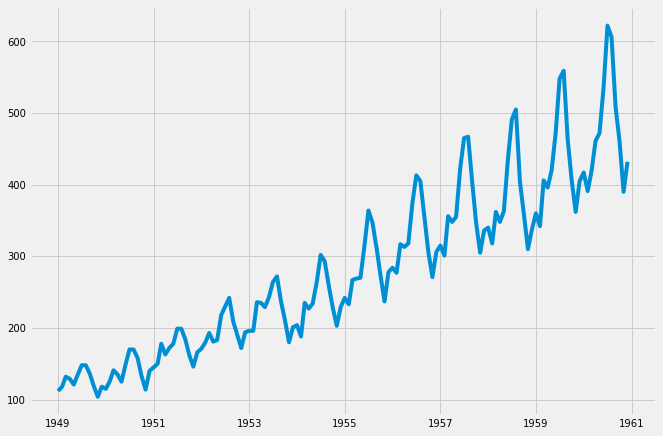

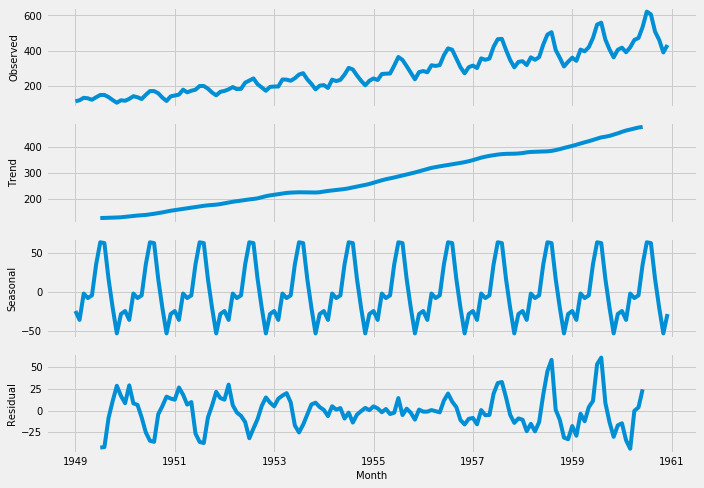

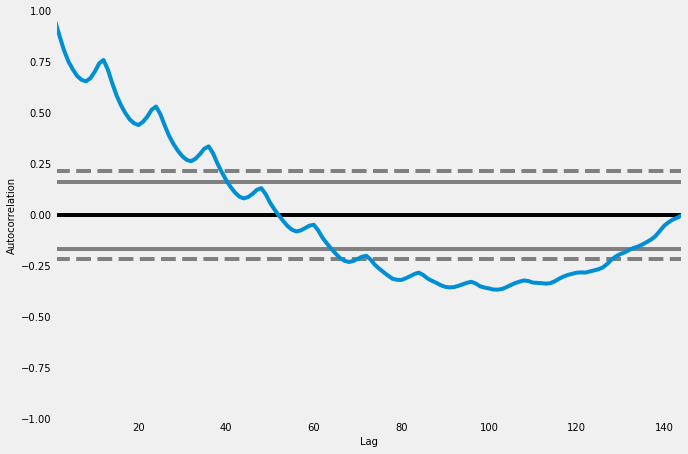

In [6]:
# ---------------------------------
# Visualise Time Series Dataset
# ---------------------------------
# Plot Dataset
plt.plot(dataset)
plt.show()

print('\n\n\n')

# Decompose diffentent Time Series elements e.g. trand, seasonality, Residual ... ...
decomposition = sm.tsa.seasonal_decompose(dataset, model='additive')
decomposition.plot()
plt.show()

print('\n\n\n')

# Auto-correlation plot
autocorrelation_plot(dataset)
plt.show()

In [8]:
# -------------------------------------------------------
# Grid Search for parameters - HoltWinters Model Model 
# -------------------------------------------------------
warnings.simplefilter("ignore")

trend = ["add", "mul"]
damped = [True, False]
seasonal = ["add", "mul"]
    
pdq = list(itertools.product(trend, damped, seasonal)) # it replaces loop for iteration
print(pdq)

params = []
AICs = []

print()
for param in pdq:
        try:
            mod = statsmodels.tsa.holtwinters.ExponentialSmoothing(dataset, 
                        trend=param[0], damped=param[1], seasonal=param[2], 
                        seasonal_periods=12)
            results = mod.fit()
                
            print()
            print("Parameter values for trend, damped and seasonal {}".format(param))
            print('holtwinters.ExponentialSmoothing{} - AIC:{}'.format(param, results.aic))
            print()
            
            if(np.isnan(results.aic)):
                pass            
            else:
                params.append(param)
                AICs.append(results.aic)
        except:
                continue

# Get the index of minimum AIC from the list
index_min_aic = np.argmin(AICs)

# Best parameter sets (trend, dumped, seasonal) for ExponentialSmoothing
print(params[index_min_aic])
print(AICs[index_min_aic])

[('add', True, 'add'), ('add', True, 'mul'), ('add', False, 'add'), ('add', False, 'mul'), ('mul', True, 'add'), ('mul', True, 'mul'), ('mul', False, 'add'), ('mul', False, 'mul')]


Parameter values for trend, damped and seasonal ('add', True, 'add')
holtwinters.ExponentialSmoothing('add', True, 'add') - AIC:760.2937092586792


Parameter values for trend, damped and seasonal ('add', True, 'mul')
holtwinters.ExponentialSmoothing('add', True, 'mul') - AIC:711.8917280494077


Parameter values for trend, damped and seasonal ('add', False, 'add')
holtwinters.ExponentialSmoothing('add', False, 'add') - AIC:758.2937094834934


Parameter values for trend, damped and seasonal ('add', False, 'mul')
holtwinters.ExponentialSmoothing('add', False, 'mul') - AIC:709.8917204225885


Parameter values for trend, damped and seasonal ('mul', True, 'add')
holtwinters.ExponentialSmoothing('mul', True, 'add') - AIC:826.9982113453708


Parameter values for trend, damped and seasonal ('mul', True, 'mul')
holt

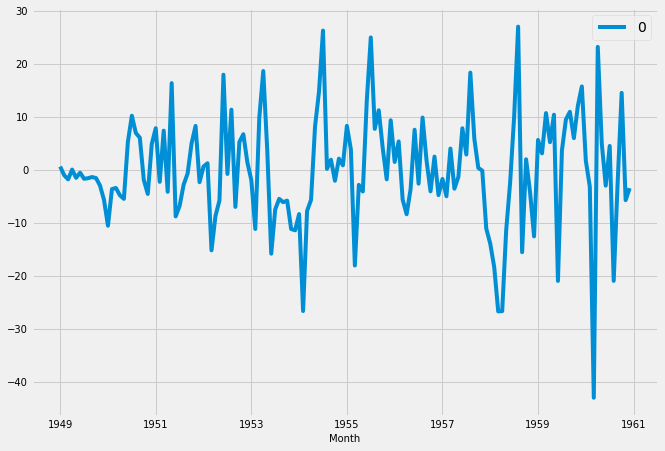

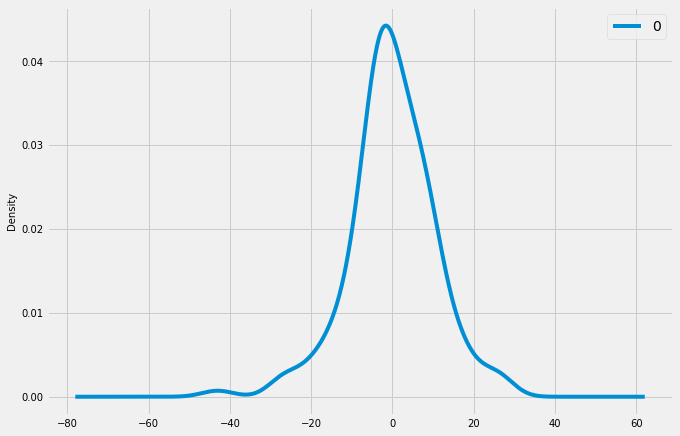

                0
count  144.000000
mean    -0.114752
std     10.438098
min    -43.029289
25%     -5.100168
50%     -0.884862
75%      5.910925
max     27.051878


In [9]:
# ----------------------------------------------------------------
# Fit ExponentialSmoothing Model with the best parameter sets
# ----------------------------------------------------------------
model = statsmodels.tsa.holtwinters.ExponentialSmoothing(dataset, 
                        trend     =params[index_min_aic][0], 
                        damped    =params[index_min_aic][1], 
                        seasonal  =params[index_min_aic][2], 
                        seasonal_periods=12)    
results = model.fit()

# plot residual errors
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()

print()

residuals.plot(kind='kde')
plt.show()
    
print(residuals.describe())

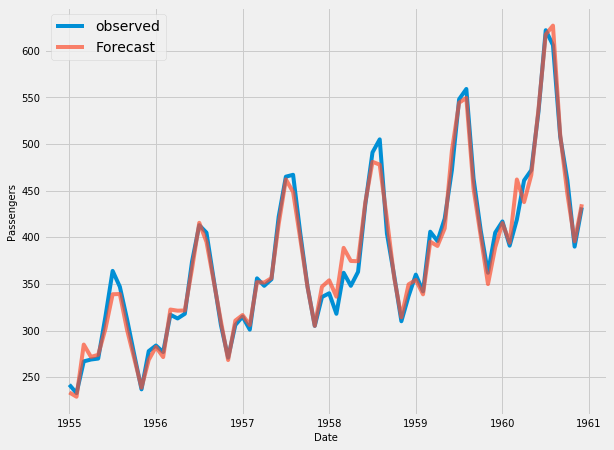

In [10]:
# ------------------------------------------------
# Validating forecasts from the fitted model
# ------------------------------------------------
pred    = results.predict(start=pd.to_datetime('1955-01'))
actual  = dataset['1955-01':].plot(label='observed')
    
pred.plot(ax=actual, label='Forecast', alpha=.7, figsize=(9, 7))

actual.set_xlabel('Date')
actual.set_ylabel('Passengers')
plt.legend()
plt.show()

In [12]:
# -------------------------------------------------------
# Evaluating the model using different KPIs or metrics
# -------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
y_forecasted    = results.predict(start=pd.to_datetime('1955-01'))
y_truth         = dataset['1955-01':]

coefficient_of_dermination = r2_score(y_truth, y_forecasted)
print("R squared: ", coefficient_of_dermination)

mae = mean_absolute_error(y_truth, y_forecasted)
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))

mse = mean_squared_error(y_truth, y_forecasted)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

msle = mean_squared_log_error(y_truth, y_forecasted)
print('The Mean Squared Log Error of our forecasts is {}'.format(round(msle, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

R squared:  0.9803905163487628
The Mean Absolute Error of our forecasts is 8.96
The Mean Squared Error of our forecasts is 144.48
The Mean Squared Log Error of our forecasts is 0.0
The Root Mean Squared Error of our forecasts is 12.02


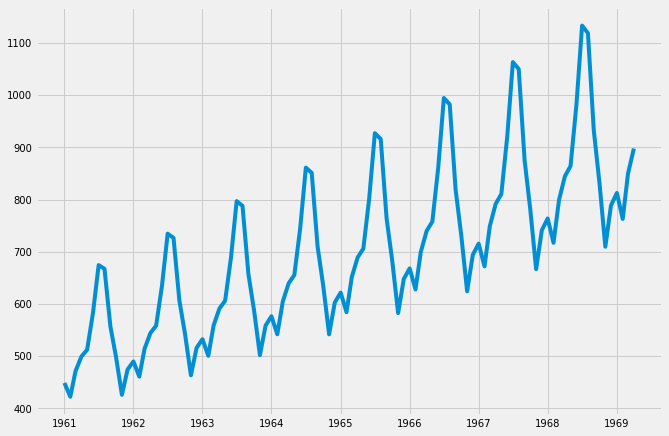


Forecasted Values: 
1961-01-01     448.744300
1961-02-01     422.288520
1961-03-01     471.560070
1961-04-01     499.382305
1961-05-01     512.253227
1961-06-01     582.648629
1961-07-01     674.495859
1961-08-01     667.240464
1961-09-01     557.294542
1961-10-01     498.437133
1961-11-01     425.990455
1961-12-01     474.419784
1962-01-01     489.849585
1962-02-01     460.804942
1962-03-01     514.386508
1962-04-01     544.541550
1962-05-01     558.378308
1962-06-01     634.888058
1962-07-01     734.711671
1962-08-01     726.553960
1962-09-01     606.622843
1962-10-01     542.367242
1962-11-01     463.375044
1962-12-01     515.876673
1963-01-01     532.472008
1963-02-01     500.728966
1963-03-01     558.762580
1963-04-01     591.318589
1963-05-01     606.139260
1963-06-01     688.961576
                 ...     
1966-11-01     624.203493
1966-12-01     694.079666
1967-01-01     715.537275
1967-02-01     672.066748
1967-03-01     749.054423
1967-04-01     791.746410
1967-05-01     81

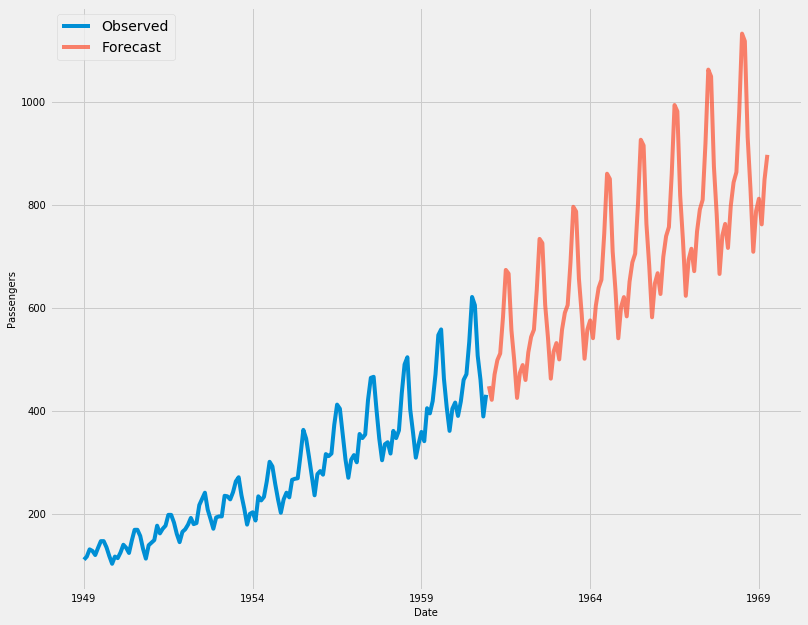

In [29]:
# -----------------------------------------------
# Forecasts (Prediction) and Visualisation
# -----------------------------------------------
pred_uc = results.forecast(steps=100)
plt.plot(pred_uc)
plt.show()
    
print()
print("Forecasted Values: ")
print(pred_uc)
    
# Visualise forecasts
print()
ax = dataset.plot(label='Observed', figsize=(12, 10))
pred_uc.plot(label='Forecast', alpha=.7, figsize=(12, 10))    
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()